In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import copy
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import SparsePCA
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.decomposition import NMF
from sklearn.ensemble import RandomForestRegressor
import subprocess
from sklearn.model_selection import RandomizedSearchCV
import sys
import math
import scipy.spatial.distance
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.tree import DecisionTreeRegressor
import os
import shutil
import glob
import shap
from scipy.stats import pearsonr

cmap='viridis'
sys.path.insert(1, '../')
from LibHelperFuncs import *

sd = 0
rstate = sd
np.random.seed(sd)
njob = -1
global_trees = 1000

plt.rcParams['axes.grid'] = False

In [2]:
originalDat = np.genfromtxt("../../Data/data_bas_preprocessing.csv", delimiter=',')
originalDat_pd = pd.read_csv("../../Data/data_bas_preprocessing_pd.csv")

X = originalDat[:,:-1]
Y = originalDat[:,-1]
C = originalDat_pd.columns

In [3]:
def compute_carried_shap(s_vals, comps, X):
    shap_values_r = np.arange(0, X.shape[0]).reshape(-1, 1)
    carried_shap_vals = np.apply_along_axis((lambda x : s_vals[x].reshape(-1, 1).T @ comps), 1, shap_values_r).reshape(-1, X.shape[1])
    return carried_shap_vals

def mean_carried_shap(s_vals, comps, X):
    
    sump = np.sqrt(np.mean(comps ** 2, axis=0))
    sump[np.where(sump == 0)[0]] = 1
    sump = sump ** 2
    sump[np.where(sump < 1e-8)[0]] = 1
    
    t = compute_carried_shap(s_vals, comps, X) / sump
    return np.mean(np.abs(t), axis=0) 

In [4]:
rf = RandomForestRegressor(n_estimators=global_trees, random_state=rstate, n_jobs=-1)
rf.fit(X, Y)

exp = shap.TreeExplainer(rf, feature_perturbation='tree_path_dependant')
s_vals = exp.shap_values(X, approximate=True)
ov_shap = np.mean(np.abs(s_vals), axis=0)

In [5]:
pca = PCA(n_components=50)
pca.fit(X)
# comps = compute_sparse_components(pca.components_, X.shape[1], 0.85)
comps = pca.components_
X_r = (comps @ X.T).T

rf = RandomForestRegressor(n_estimators=global_trees, random_state=rstate, n_jobs=-1)
rf.fit(X_r, Y)

exp = shap.TreeExplainer(rf, feature_perturbation='tree_path_dependant')
s_vals = exp.shap_values(X_r, approximate=True)
ov_reduced_shap = mean_carried_shap(s_vals, pca.components_, X)

In [6]:
rf_params = dict()
rf_params['n_estimators'] = global_trees

In [7]:
ltscores = []

renge = range(1, 120)
tsets = np.arange(0.5, 1, 0.1)

for t in tsets:
    l2scores = []

    for k in renge:
        X_r = X[:,np.argsort(ov_reduced_shap)[::-1][:k]]
        
        rf = RandomForestRegressor(n_estimators=global_trees, random_state=rstate, n_jobs=20)
        
        l2scores.append(model_eval(X_r, Y, rf, tsize=t, rstate=rstate))
    
    ltscores.append(l2scores)

In [17]:
baseline9 = []

renge = range(1, 120)
tsets = np.arange(0.5, 1, 0.1)

for k in renge:
    l2scores = []

    X_l = X[:,np.argsort(ov_shap)[::-1][:k]]

    rf = RandomForestRegressor(n_estimators=global_trees, random_state=rstate, n_jobs=20)

    baseline9.append(model_eval(X_l, Y, rf, tsize=0.9, rstate=rstate))
    print(k, baseline[k-1])

1 0.044871903208092166
2 0.038461451777355146
3 0.03430469569881383
4 0.03384145460941175
5 0.033253075429352345
6 0.031429488693668635
7 0.03207924800822452
8 0.03198109544928081
9 0.03202154740396065
10 0.03011795843651451
11 0.02994429311138012
12 0.030241582102188087
13 0.030701998679187735
14 0.030843035175857503
15 0.02921003984074078
16 0.029189904277972203
17 0.029226956567949252
18 0.029258980654394286
19 0.029243765801422867
20 0.02922931181425381
21 0.029255647942934882
22 0.029163705684586184
23 0.02926485338875826
24 0.029103638948666223
25 0.028598972013143084
26 0.02859562022785019
27 0.028737258613604908
28 0.02894670361367795
29 0.028877744663930092
30 0.02913044878879211
31 0.02910212252074409
32 0.029187950578257935
33 0.028851435700357312
34 0.028954542010411866
35 0.029043750747148933
36 0.029006345936154133
37 0.029271717396426894
38 0.029590912285531807
39 0.029488352668257632
40 0.029532073943095486
41 0.029633703696311665
42 0.029516445411445952
43 0.0293886224

In [18]:
baseline8 = []

renge = range(1, 120)
tsets = np.arange(0.5, 1, 0.1)

for k in renge:
    l2scores = []

    X_l = X[:,np.argsort(ov_shap)[::-1][:k]]

    rf = RandomForestRegressor(n_estimators=global_trees, random_state=rstate, n_jobs=20)

    baseline8.append(model_eval(X_l, Y, rf, tsize=0.8, rstate=rstate))
    print(k, baseline[k-1])

1 0.044871903208092166
2 0.038461451777355146
3 0.03430469569881383
4 0.03384145460941175
5 0.033253075429352345
6 0.031429488693668635
7 0.03207924800822452
8 0.03198109544928081
9 0.03202154740396065
10 0.03011795843651451
11 0.02994429311138012
12 0.030241582102188087
13 0.030701998679187735
14 0.030843035175857503
15 0.02921003984074078
16 0.029189904277972203
17 0.029226956567949252
18 0.029258980654394286
19 0.029243765801422867
20 0.02922931181425381
21 0.029255647942934882
22 0.029163705684586184
23 0.02926485338875826
24 0.029103638948666223
25 0.028598972013143084
26 0.02859562022785019
27 0.028737258613604908
28 0.02894670361367795
29 0.028877744663930092
30 0.02913044878879211
31 0.02910212252074409
32 0.029187950578257935
33 0.028851435700357312
34 0.028954542010411866
35 0.029043750747148933
36 0.029006345936154133
37 0.029271717396426894
38 0.029590912285531807
39 0.029488352668257632
40 0.029532073943095486
41 0.029633703696311665
42 0.029516445411445952
43 0.0293886224

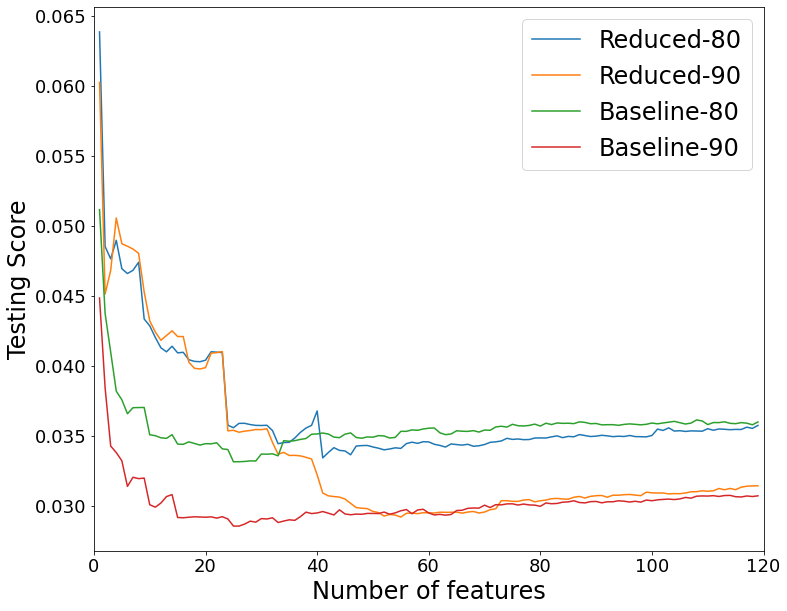

In [27]:
plt.figure(figsize=(12,10))

plt.xlim([0, 120])

for x in range(3, tsets.shape[0]):
    plt.plot(renge, ltscores[x], label='Reduced-{}'.format(int(round(tsets[x], 2) * 100)))
    
plt.plot(renge, baseline8, label='Baseline-80')
plt.plot(renge, baseline9, label='Baseline-90')
    
plt.xlabel('Number of features', fontsize=24)
plt.ylabel("Testing Score", fontsize=24)
    
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.legend(fontsize=24)